# Conditional Average Treatment Effects (CATE) with DoWhy and EconML

This is an experimental feature where we use [EconML](https://github.com/microsoft/econml) methods from DoWhy. Using EconML allows CATE estimation using different methods. 

All four steps of causal inference in DoWhy remain the same: model, identify, estimate, and refute. The key difference is that we now call econml methods in the estimation step. There is also a simpler example using linear regression to understand the intuition behind CATE estimators. 

All datasets are generated using linear structural equations.



In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import logging

import dowhy
from dowhy import CausalModel
import dowhy.datasets

import econml
import warnings
warnings.filterwarnings('ignore')

BETA = 10

In [3]:
data = dowhy.datasets.linear_dataset(BETA, num_common_causes=4, num_samples=10000,
                                    num_instruments=2, num_effect_modifiers=2,
                                     num_treatments=1,
                                    treatment_is_binary=False,
                                    num_discrete_common_causes=2,
                                    num_discrete_effect_modifiers=0,
                                    one_hot_encode=False)
df=data['df']
print(df.head())
print("True causal estimate is", data["ate"])

         X0        X1   Z0        Z1        W0        W1 W2 W3         v0  \
0 -0.311511  1.844202  0.0  0.827461  0.470883 -1.140811  1  0   6.688214   
1 -1.336245  1.090141  0.0  0.383612  1.488992 -1.065476  3  3  20.693274   
2 -0.916552  0.576585  0.0  0.594587  0.943198 -0.549350  2  2  17.808414   
3 -1.350428  0.587912  0.0  0.907548  1.690149  0.806864  2  0  23.971001   
4 -0.734374  3.014866  0.0  0.539074  2.897271 -0.438651  3  3  27.371593   

            y  
0  118.007900  
1  265.751305  
2  201.201070  
3  251.498420  
4  614.634098  
True causal estimate is 12.469408871440187


In [4]:
model = CausalModel(data=data["df"], 
                    treatment=data["treatment_name"], outcome=data["outcome_name"], 
                    graph=data["gml_graph"])

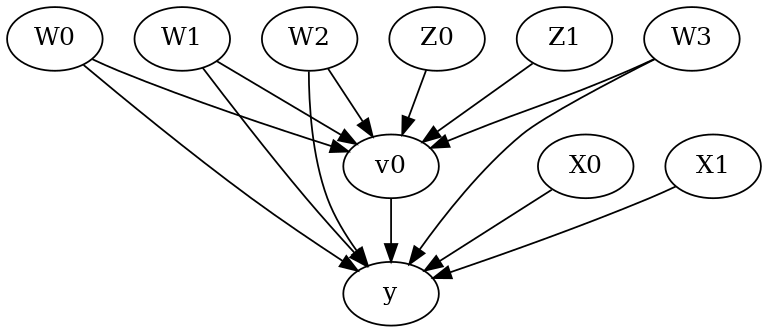

In [5]:
model.view_model()
from IPython.display import Image, display
display(Image(filename="causal_model.png"))

In [6]:
identified_estimand= model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                    
─────(E[y|W0,W1,W3,W2])
d[v₀]                  
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W0,W1,W3,W2,U) = P(y|v0,W0,W1,W3,W2)

### Estimand : 2
Estimand name: iv
Estimand expression:
 ⎡                              -1⎤
 ⎢    d        ⎛    d          ⎞  ⎥
E⎢─────────(y)⋅⎜─────────([v₀])⎟  ⎥
 ⎣d[Z₀  Z₁]    ⎝d[Z₀  Z₁]      ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z0,Z1})
Estimand assumption 2, Exclusion: If we remove {Z0,Z1}→{v0}, then ¬({Z0,Z1}→y)

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



## Linear Model 
First, let us build some intuition using a linear model for estimating CATE. The effect modifiers (that lead to a heterogeneous treatment effect) can be modeled as interaction terms with the treatment. Thus, their value modulates the effect of treatment. 

Below the estimated effect of changing treatment from 0 to 1. 

In [7]:
linear_estimate = model.estimate_effect(identified_estimand, 
                                        method_name="backdoor.linear_regression",
                                       control_value=0,
                                       treatment_value=1)
print(linear_estimate) 

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                    
─────(E[y|W0,W1,W3,W2])
d[v₀]                  
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W0,W1,W3,W2,U) = P(y|v0,W0,W1,W3,W2)

## Realized estimand
b: y~v0+W0+W1+W3+W2+v0*X1+v0*X0
Target units: ate

## Estimate
Mean value: 12.469417478868147



## EconML methods
We now move to the more advanced methods from the EconML package for estimating CATE.

First, let us look at the double machine learning estimator. Method_name corresponds to the fully qualified name of the class that we want to use. For double ML, it is "econml.dml.DML". 

Target units defines the units over which the causal estimate is to be computed. This can be a lambda function filter on the original dataframe, a new Pandas dataframe, or a string corresponding to the three main kinds of target units ("ate", "att" and "atc"). Below we show an example of a lambda function. 

Method_params are passed directly to EconML. For details on allowed parameters, refer to the EconML documentation. 

In [8]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV
from sklearn.ensemble import GradientBoostingRegressor
dml_estimate = model.estimate_effect(identified_estimand, method_name="backdoor.econml.dml.DML",
                                     control_value = 0,
                                     treatment_value = 1,
                                 target_units = lambda df: df["X0"]>1,  # condition used for CATE
                                 confidence_intervals=False,
                                method_params={"init_params":{'model_y':GradientBoostingRegressor(),
                                                              'model_t': GradientBoostingRegressor(),
                                                              "model_final":LassoCV(fit_intercept=False), 
                                                              'featurizer':PolynomialFeatures(degree=1, include_bias=False)},
                                               "fit_params":{}})
print(dml_estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                    
─────(E[y|W0,W1,W3,W2])
d[v₀]                  
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W0,W1,W3,W2,U) = P(y|v0,W0,W1,W3,W2)

## Realized estimand
b: y~v0+W0+W1+W3+W2 | X1,X0
Target units: Data subset defined by a function

## Estimate
Mean value: 16.81793653468245
Effect estimates: [[19.79479596]
 [20.19878002]
 [15.07748192]
 [10.72962146]
 [25.50889648]
 [14.98127612]
 [14.82988061]
 [ 6.26258896]
 [ 9.57781915]
 [14.60837676]
 [13.42811124]
 [13.12635505]
 [19.8662957 ]
 [16.0882504 ]
 [16.54507631]
 [12.01848289]
 [13.98078909]
 [18.38786073]
 [18.63256722]
 [12.93614827]
 [22.73088335]
 [14.52073778]
 [18.54419029]
 [15.79089353]
 [13.38529991]
 [22.60528479]
 [14.33695079]
 [14.30600734]
 [20.33706418]
 [19.77077713]
 [15.80760701]
 [22.30514081]
 [ 3.17169227]
 [16.8520

In [9]:
print("True causal estimate is", data["ate"])

True causal estimate is 12.469408871440187


In [10]:
dml_estimate = model.estimate_effect(identified_estimand, method_name="backdoor.econml.dml.DML",
                                     control_value = 0,
                                     treatment_value = 1,
                                 target_units = 1,  # condition used for CATE
                                 confidence_intervals=False,
                                method_params={"init_params":{'model_y':GradientBoostingRegressor(),
                                                              'model_t': GradientBoostingRegressor(),
                                                              "model_final":LassoCV(fit_intercept=False), 
                                                              'featurizer':PolynomialFeatures(degree=1, include_bias=True)},
                                               "fit_params":{}})
print(dml_estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                    
─────(E[y|W0,W1,W3,W2])
d[v₀]                  
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W0,W1,W3,W2,U) = P(y|v0,W0,W1,W3,W2)

## Realized estimand
b: y~v0+W0+W1+W3+W2 | X1,X0
Target units: 

## Estimate
Mean value: 12.429071596490132
Effect estimates: [[17.46936083]
 [11.94341683]
 [10.55933101]
 ...
 [12.74942502]
 [17.52323738]
 [11.37059798]]



### CATE Object and Confidence Intervals
EconML provides its own methods to compute confidence intervals. Using BootstrapInference in the example below. 

In [11]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV
from sklearn.ensemble import GradientBoostingRegressor
from econml.inference import BootstrapInference
dml_estimate = model.estimate_effect(identified_estimand, 
                                     method_name="backdoor.econml.dml.DML",
                                     target_units = "ate",
                                     confidence_intervals=True,
                                     method_params={"init_params":{'model_y':GradientBoostingRegressor(),
                                                              'model_t': GradientBoostingRegressor(),
                                                              "model_final": LassoCV(fit_intercept=False), 
                                                              'featurizer':PolynomialFeatures(degree=1, include_bias=True)},
                                               "fit_params":{
                                                               'inference': BootstrapInference(n_bootstrap_samples=100, n_jobs=-1),
                                                            }
                                              })
print(dml_estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                    
─────(E[y|W0,W1,W3,W2])
d[v₀]                  
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W0,W1,W3,W2,U) = P(y|v0,W0,W1,W3,W2)

## Realized estimand
b: y~v0+W0+W1+W3+W2 | X1,X0
Target units: ate

## Estimate
Mean value: 12.4021409709485
Effect estimates: [[17.42695412]
 [11.91974717]
 [10.53750772]
 ...
 [12.72075107]
 [17.4761078 ]
 [11.3420397 ]]
95.0% confidence interval: [[[17.55336683 11.95612824 10.53501593 ... 12.79491861 17.61291545
   11.32524669]]

 [[18.04223903 12.20331713 10.78142848 ... 13.06651874 18.18883164
   11.76334551]]]



### Can provide a new inputs as target units and estimate CATE on them.

In [12]:
test_cols= data['effect_modifier_names'] # only need effect modifiers' values
test_arr = [np.random.uniform(0,1, 10) for _ in range(len(test_cols))] # all variables are sampled uniformly, sample of 10
test_df = pd.DataFrame(np.array(test_arr).transpose(), columns=test_cols)
dml_estimate = model.estimate_effect(identified_estimand, 
                                     method_name="backdoor.econml.dml.DML",
                                     target_units = test_df,
                                     confidence_intervals=False,
                                     method_params={"init_params":{'model_y':GradientBoostingRegressor(),
                                                              'model_t': GradientBoostingRegressor(),
                                                              "model_final":LassoCV(), 
                                                              'featurizer':PolynomialFeatures(degree=1, include_bias=True)},
                                               "fit_params":{}
                                              })
print(dml_estimate.cate_estimates)

[[14.90977185]
 [11.66602401]
 [12.83008826]
 [13.33114504]
 [13.4492219 ]
 [12.88670892]
 [12.14490513]
 [13.78228967]
 [11.35009437]
 [13.06827209]]


### Can also retrieve the raw EconML estimator object for any further operations

In [13]:
print(dml_estimate._estimator_object)

## Works with any EconML method
In addition to double machine learning, below we example analyses using orthogonal forests, DRLearner (bug to fix), and neural network-based instrumental variables. 

### Binary treatment, Binary outcome

In [14]:
data_binary = dowhy.datasets.linear_dataset(BETA, num_common_causes=4, num_samples=10000,
                                    num_instruments=2, num_effect_modifiers=2,
                                    treatment_is_binary=True, outcome_is_binary=True)
# convert boolean values to {0,1} numeric
data_binary['df'].v0 = data_binary['df'].v0.astype(int)
data_binary['df'].y = data_binary['df'].y.astype(int)
print(data_binary['df'])

model_binary = CausalModel(data=data_binary["df"], 
                    treatment=data_binary["treatment_name"], outcome=data_binary["outcome_name"], 
                    graph=data_binary["gml_graph"])
identified_estimand_binary = model_binary.identify_effect(proceed_when_unidentifiable=True)

            X0        X1   Z0        Z1        W0        W1        W2  \
0    -0.051968 -1.164661  1.0  0.547647  1.257354  0.144635 -1.915298   
1     0.309273 -1.629227  1.0  0.978838  0.207110  0.785709  0.745674   
2     0.117311 -0.577682  0.0  0.811919  1.796605  1.277163 -1.591599   
3    -0.685102 -0.565104  1.0  0.906028  0.754113  0.179038  0.849158   
4    -1.254290 -0.229135  0.0  0.472972 -0.413652 -0.349310 -1.208554   
...        ...       ...  ...       ...       ...       ...       ...   
9995 -1.337895 -0.780002  1.0  0.456712 -0.703563 -0.167670  0.517025   
9996 -0.946419 -0.687119  1.0  0.002797  1.965792  0.609639 -0.069119   
9997  1.556394  0.386330  1.0  0.324715  0.566451 -0.050237  0.564942   
9998  0.794707 -1.232697  1.0  0.721695 -0.535883  0.611294 -1.585460   
9999  0.108873 -0.389993  1.0  0.593945  1.447407  1.860366  0.548102   

            W3  v0  y  
0     0.946188   1  1  
1     0.140948   1  1  
2     1.322385   1  1  
3     0.648260   1  1  
4  

#### Using DRLearner estimator

In [15]:
from sklearn.linear_model import LogisticRegressionCV
#todo needs binary y
drlearner_estimate = model_binary.estimate_effect(identified_estimand_binary, 
                                method_name="backdoor.econml.dr.LinearDRLearner",
                                confidence_intervals=False,
                                method_params={"init_params":{
                                                    'model_propensity': LogisticRegressionCV(cv=3, solver='lbfgs', multi_class='auto')
                                                    },
                                               "fit_params":{}
                                              })
print(drlearner_estimate)
print("True causal estimate is", data_binary["ate"])

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                    
─────(E[y|W0,W1,W3,W2])
d[v₀]                  
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W0,W1,W3,W2,U) = P(y|v0,W0,W1,W3,W2)

## Realized estimand
b: y~v0+W0+W1+W3+W2 | X1,X0
Target units: ate

## Estimate
Mean value: 0.4263324580799472
Effect estimates: [[0.39483359]
 [0.3773944 ]
 [0.44517642]
 ...
 [0.58038551]
 [0.42819173]
 [0.45844313]]

True causal estimate is 0.1637


### Instrumental Variable Method

In [16]:
import keras
dims_zx = len(model.get_instruments())+len(model.get_effect_modifiers())
dims_tx = len(model._treatment)+len(model.get_effect_modifiers())
treatment_model = keras.Sequential([keras.layers.Dense(128, activation='relu', input_shape=(dims_zx,)), # sum of dims of Z and X 
                                    keras.layers.Dropout(0.17),
                                    keras.layers.Dense(64, activation='relu'),
                                    keras.layers.Dropout(0.17),
                                    keras.layers.Dense(32, activation='relu'),
                                    keras.layers.Dropout(0.17)])                
response_model = keras.Sequential([keras.layers.Dense(128, activation='relu', input_shape=(dims_tx,)), # sum of dims of T and X
                                    keras.layers.Dropout(0.17), 
                                    keras.layers.Dense(64, activation='relu'),
                                    keras.layers.Dropout(0.17),
                                    keras.layers.Dense(32, activation='relu'),
                                    keras.layers.Dropout(0.17),
                                    keras.layers.Dense(1)])

deepiv_estimate = model.estimate_effect(identified_estimand, 
                                        method_name="iv.econml.iv.nnet.DeepIV",
                                        target_units = lambda df: df["X0"]>-1, 
                                        confidence_intervals=False,
                                method_params={"init_params":{'n_components': 10, # Number of gaussians in the mixture density networks
                                                              'm': lambda z, x: treatment_model(keras.layers.concatenate([z, x])), # Treatment model,
                                                              "h": lambda t, x: response_model(keras.layers.concatenate([t, x])), # Response model
                                                              'n_samples': 1, # Number of samples used to estimate the response
                                                              'first_stage_options': {'epochs':25},
                                                              'second_stage_options': {'epochs':25}
                                                             },
                                               "fit_params":{}})
print(deepiv_estimate)

2023-03-06 15:44:25.927772: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-06 15:44:26.065251: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-06 15:44:26.065277: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


2023-03-06 15:44:26.811584: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-03-06 15:44:26.811709: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-03-06 15:44:26.811719: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


2023-03-06 15:44:27.614071: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-03-06 15:44:27.614105: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-06 15:44:27.614130: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (2da9aa5403e9): /proc/driver/nvidia/version does not exist
2023-03-06 15:44:27.614681: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/25


  1/313 [..............................] - ETA: 5:27 - loss: 146.0171

 33/313 [==>...........................] - ETA: 0s - loss: 57.6029   

 65/313 [=====>........................] - ETA: 0s - loss: 33.1553

 99/313 [========>.....................] - ETA: 0s - loss: 23.8174

132/313 [===========>..................] - ETA: 0s - loss: 19.0690

167/313 [===============>..............] - ETA: 0s - loss: 16.0143

201/313 [==================>...........] - ETA: 0s - loss: 14.0428

235/313 [=====================>........] - ETA: 0s - loss: 12.6285

270/313 [========================>.....] - ETA: 0s - loss: 11.5269

304/313 [============================>.] - ETA: 0s - loss: 10.6903

313/313 [==============================] - 2s 2ms/step - loss: 10.4955


Epoch 2/25


  1/313 [..............................] - ETA: 0s - loss: 3.9494

 35/313 [==>...........................] - ETA: 0s - loss: 3.9354

 69/313 [=====>........................] - ETA: 0s - loss: 3.8736

103/313 [========>.....................] - ETA: 0s - loss: 3.8462

137/313 [============>.................] - ETA: 0s - loss: 3.8042

171/313 [===============>..............] - ETA: 0s - loss: 3.7612

205/313 [==================>...........] - ETA: 0s - loss: 3.7238

239/313 [=====================>........] - ETA: 0s - loss: 3.6774

273/313 [=========================>....] - ETA: 0s - loss: 3.6246

307/313 [============================>.] - ETA: 0s - loss: 3.5697

313/313 [==============================] - 0s 1ms/step - loss: 3.5599


Epoch 3/25


  1/313 [..............................] - ETA: 1s - loss: 3.0355

 36/313 [==>...........................] - ETA: 0s - loss: 3.0392

 70/313 [=====>........................] - ETA: 0s - loss: 3.0364

104/313 [========>.....................] - ETA: 0s - loss: 3.0531

138/313 [============>.................] - ETA: 0s - loss: 3.0289

172/313 [===============>..............] - ETA: 0s - loss: 3.0149

206/313 [==================>...........] - ETA: 0s - loss: 3.0004

239/313 [=====================>........] - ETA: 0s - loss: 2.9921

273/313 [=========================>....] - ETA: 0s - loss: 2.9795

308/313 [============================>.] - ETA: 0s - loss: 2.9673

313/313 [==============================] - 0s 1ms/step - loss: 2.9660


Epoch 4/25


  1/313 [..............................] - ETA: 0s - loss: 2.9222

 36/313 [==>...........................] - ETA: 0s - loss: 2.8525

 70/313 [=====>........................] - ETA: 0s - loss: 2.8583

104/313 [========>.....................] - ETA: 0s - loss: 2.8537

137/313 [============>.................] - ETA: 0s - loss: 2.8526

172/313 [===============>..............] - ETA: 0s - loss: 2.8464

206/313 [==================>...........] - ETA: 0s - loss: 2.8447

240/313 [======================>.......] - ETA: 0s - loss: 2.8348

275/313 [=========================>....] - ETA: 0s - loss: 2.8249

310/313 [============================>.] - ETA: 0s - loss: 2.8148

313/313 [==============================] - 0s 1ms/step - loss: 2.8146


Epoch 5/25


  1/313 [..............................] - ETA: 0s - loss: 2.8206

 36/313 [==>...........................] - ETA: 0s - loss: 2.8225

 70/313 [=====>........................] - ETA: 0s - loss: 2.7955

104/313 [========>.....................] - ETA: 0s - loss: 2.7836

139/313 [============>.................] - ETA: 0s - loss: 2.7718

173/313 [===============>..............] - ETA: 0s - loss: 2.7599

207/313 [==================>...........] - ETA: 0s - loss: 2.7576

242/313 [======================>.......] - ETA: 0s - loss: 2.7552

276/313 [=========================>....] - ETA: 0s - loss: 2.7539

311/313 [============================>.] - ETA: 0s - loss: 2.7517

313/313 [==============================] - 0s 1ms/step - loss: 2.7521


Epoch 6/25


  1/313 [..............................] - ETA: 0s - loss: 2.7059

 36/313 [==>...........................] - ETA: 0s - loss: 2.7079

 71/313 [=====>........................] - ETA: 0s - loss: 2.7067

106/313 [=========>....................] - ETA: 0s - loss: 2.7235

141/313 [============>.................] - ETA: 0s - loss: 2.7154

176/313 [===============>..............] - ETA: 0s - loss: 2.7171

211/313 [===================>..........] - ETA: 0s - loss: 2.7213

246/313 [======================>.......] - ETA: 0s - loss: 2.7236

279/313 [=========================>....] - ETA: 0s - loss: 2.7220

313/313 [==============================] - ETA: 0s - loss: 2.7199

313/313 [==============================] - 0s 1ms/step - loss: 2.7199


Epoch 7/25


  1/313 [..............................] - ETA: 0s - loss: 2.6564

 35/313 [==>...........................] - ETA: 0s - loss: 2.7092

 69/313 [=====>........................] - ETA: 0s - loss: 2.7023

103/313 [========>.....................] - ETA: 0s - loss: 2.7074

137/313 [============>.................] - ETA: 0s - loss: 2.7047

171/313 [===============>..............] - ETA: 0s - loss: 2.7042

205/313 [==================>...........] - ETA: 0s - loss: 2.7053

239/313 [=====================>........] - ETA: 0s - loss: 2.7053

271/313 [========================>.....] - ETA: 0s - loss: 2.7020

302/313 [===========================>..] - ETA: 0s - loss: 2.6993

313/313 [==============================] - 0s 2ms/step - loss: 2.6984


Epoch 8/25


  1/313 [..............................] - ETA: 0s - loss: 2.7712

 36/313 [==>...........................] - ETA: 0s - loss: 2.6644

 71/313 [=====>........................] - ETA: 0s - loss: 2.6779

106/313 [=========>....................] - ETA: 0s - loss: 2.6681

141/313 [============>.................] - ETA: 0s - loss: 2.6616

176/313 [===============>..............] - ETA: 0s - loss: 2.6591

210/313 [===================>..........] - ETA: 0s - loss: 2.6608

243/313 [======================>.......] - ETA: 0s - loss: 2.6630

278/313 [=========================>....] - ETA: 0s - loss: 2.6591

313/313 [==============================] - ETA: 0s - loss: 2.6650

313/313 [==============================] - 0s 1ms/step - loss: 2.6650


Epoch 9/25


  1/313 [..............................] - ETA: 0s - loss: 2.7745

 35/313 [==>...........................] - ETA: 0s - loss: 2.6781

 69/313 [=====>........................] - ETA: 0s - loss: 2.6304

104/313 [========>.....................] - ETA: 0s - loss: 2.6497

137/313 [============>.................] - ETA: 0s - loss: 2.6490

170/313 [===============>..............] - ETA: 0s - loss: 2.6526

204/313 [==================>...........] - ETA: 0s - loss: 2.6480

239/313 [=====================>........] - ETA: 0s - loss: 2.6492

272/313 [=========================>....] - ETA: 0s - loss: 2.6490

306/313 [============================>.] - ETA: 0s - loss: 2.6496

313/313 [==============================] - 0s 1ms/step - loss: 2.6500


Epoch 10/25


  1/313 [..............................] - ETA: 0s - loss: 2.5142

 36/313 [==>...........................] - ETA: 0s - loss: 2.6429

 71/313 [=====>........................] - ETA: 0s - loss: 2.6421

105/313 [=========>....................] - ETA: 0s - loss: 2.6345

139/313 [============>.................] - ETA: 0s - loss: 2.6330

173/313 [===============>..............] - ETA: 0s - loss: 2.6421

206/313 [==================>...........] - ETA: 0s - loss: 2.6395

239/313 [=====================>........] - ETA: 0s - loss: 2.6428

273/313 [=========================>....] - ETA: 0s - loss: 2.6419

306/313 [============================>.] - ETA: 0s - loss: 2.6407

313/313 [==============================] - 0s 2ms/step - loss: 2.6405


Epoch 11/25


  1/313 [..............................] - ETA: 1s - loss: 2.8167

 36/313 [==>...........................] - ETA: 0s - loss: 2.6321

 70/313 [=====>........................] - ETA: 0s - loss: 2.6386

104/313 [========>.....................] - ETA: 0s - loss: 2.6409

138/313 [============>.................] - ETA: 0s - loss: 2.6383

171/313 [===============>..............] - ETA: 0s - loss: 2.6326

206/313 [==================>...........] - ETA: 0s - loss: 2.6285

239/313 [=====================>........] - ETA: 0s - loss: 2.6297

273/313 [=========================>....] - ETA: 0s - loss: 2.6290

308/313 [============================>.] - ETA: 0s - loss: 2.6264

313/313 [==============================] - 0s 1ms/step - loss: 2.6267


Epoch 12/25


  1/313 [..............................] - ETA: 0s - loss: 2.5932

 37/313 [==>...........................] - ETA: 0s - loss: 2.5742

 71/313 [=====>........................] - ETA: 0s - loss: 2.5971

105/313 [=========>....................] - ETA: 0s - loss: 2.6089

138/313 [============>.................] - ETA: 0s - loss: 2.6197

170/313 [===============>..............] - ETA: 0s - loss: 2.6224

203/313 [==================>...........] - ETA: 0s - loss: 2.6260

237/313 [=====================>........] - ETA: 0s - loss: 2.6231

271/313 [========================>.....] - ETA: 0s - loss: 2.6206

304/313 [============================>.] - ETA: 0s - loss: 2.6198

313/313 [==============================] - 0s 2ms/step - loss: 2.6200


Epoch 13/25


  1/313 [..............................] - ETA: 0s - loss: 2.3369

 36/313 [==>...........................] - ETA: 0s - loss: 2.6026

 69/313 [=====>........................] - ETA: 0s - loss: 2.6297

104/313 [========>.....................] - ETA: 0s - loss: 2.6175

139/313 [============>.................] - ETA: 0s - loss: 2.6237

174/313 [===============>..............] - ETA: 0s - loss: 2.6231

209/313 [===================>..........] - ETA: 0s - loss: 2.6242

244/313 [======================>.......] - ETA: 0s - loss: 2.6227

278/313 [=========================>....] - ETA: 0s - loss: 2.6229

313/313 [==============================] - ETA: 0s - loss: 2.6157

313/313 [==============================] - 0s 1ms/step - loss: 2.6157


Epoch 14/25


  1/313 [..............................] - ETA: 0s - loss: 2.4843

 36/313 [==>...........................] - ETA: 0s - loss: 2.6056

 70/313 [=====>........................] - ETA: 0s - loss: 2.6069

104/313 [========>.....................] - ETA: 0s - loss: 2.5922

138/313 [============>.................] - ETA: 0s - loss: 2.6009

173/313 [===============>..............] - ETA: 0s - loss: 2.6001

207/313 [==================>...........] - ETA: 0s - loss: 2.6018

242/313 [======================>.......] - ETA: 0s - loss: 2.6039

270/313 [========================>.....] - ETA: 0s - loss: 2.6064

301/313 [===========================>..] - ETA: 0s - loss: 2.6066

313/313 [==============================] - 0s 2ms/step - loss: 2.6056


Epoch 15/25


  1/313 [..............................] - ETA: 1s - loss: 2.6956

 31/313 [=>............................] - ETA: 0s - loss: 2.6564

 63/313 [=====>........................] - ETA: 0s - loss: 2.6370

 95/313 [========>.....................] - ETA: 0s - loss: 2.6129

130/313 [===========>..................] - ETA: 0s - loss: 2.6039

165/313 [==============>...............] - ETA: 0s - loss: 2.5999

197/313 [=================>............] - ETA: 0s - loss: 2.6037

231/313 [=====================>........] - ETA: 0s - loss: 2.6073

264/313 [========================>.....] - ETA: 0s - loss: 2.6048

298/313 [===========================>..] - ETA: 0s - loss: 2.6067

313/313 [==============================] - 0s 2ms/step - loss: 2.6053


Epoch 16/25


  1/313 [..............................] - ETA: 1s - loss: 2.5745

 34/313 [==>...........................] - ETA: 0s - loss: 2.5897

 69/313 [=====>........................] - ETA: 0s - loss: 2.6014

101/313 [========>.....................] - ETA: 0s - loss: 2.6017

133/313 [===========>..................] - ETA: 0s - loss: 2.6038

166/313 [==============>...............] - ETA: 0s - loss: 2.5993

199/313 [==================>...........] - ETA: 0s - loss: 2.5942

233/313 [=====================>........] - ETA: 0s - loss: 2.5981

267/313 [========================>.....] - ETA: 0s - loss: 2.6010

302/313 [===========================>..] - ETA: 0s - loss: 2.5996

313/313 [==============================] - 0s 2ms/step - loss: 2.5970


Epoch 17/25


  1/313 [..............................] - ETA: 0s - loss: 2.5405

 36/313 [==>...........................] - ETA: 0s - loss: 2.5977

 70/313 [=====>........................] - ETA: 0s - loss: 2.5974

103/313 [========>.....................] - ETA: 0s - loss: 2.5974

135/313 [===========>..................] - ETA: 0s - loss: 2.5918

170/313 [===============>..............] - ETA: 0s - loss: 2.5872

205/313 [==================>...........] - ETA: 0s - loss: 2.5898

239/313 [=====================>........] - ETA: 0s - loss: 2.5884

273/313 [=========================>....] - ETA: 0s - loss: 2.5870

307/313 [============================>.] - ETA: 0s - loss: 2.5865

313/313 [==============================] - 0s 1ms/step - loss: 2.5853


Epoch 18/25


  1/313 [..............................] - ETA: 0s - loss: 2.2973

 36/313 [==>...........................] - ETA: 0s - loss: 2.5961

 71/313 [=====>........................] - ETA: 0s - loss: 2.5919

106/313 [=========>....................] - ETA: 0s - loss: 2.5920

141/313 [============>.................] - ETA: 0s - loss: 2.5910

175/313 [===============>..............] - ETA: 0s - loss: 2.5854

210/313 [===================>..........] - ETA: 0s - loss: 2.5849

245/313 [======================>.......] - ETA: 0s - loss: 2.5860

280/313 [=========================>....] - ETA: 0s - loss: 2.5839

313/313 [==============================] - 0s 1ms/step - loss: 2.5844


Epoch 19/25


  1/313 [..............................] - ETA: 0s - loss: 2.4490

 35/313 [==>...........................] - ETA: 0s - loss: 2.5857

 69/313 [=====>........................] - ETA: 0s - loss: 2.5830

102/313 [========>.....................] - ETA: 0s - loss: 2.5784

137/313 [============>.................] - ETA: 0s - loss: 2.5797

171/313 [===============>..............] - ETA: 0s - loss: 2.5763

204/313 [==================>...........] - ETA: 0s - loss: 2.5732

238/313 [=====================>........] - ETA: 0s - loss: 2.5770

272/313 [=========================>....] - ETA: 0s - loss: 2.5793

305/313 [============================>.] - ETA: 0s - loss: 2.5833

313/313 [==============================] - 0s 2ms/step - loss: 2.5847


Epoch 20/25


  1/313 [..............................] - ETA: 0s - loss: 2.5341

 35/313 [==>...........................] - ETA: 0s - loss: 2.5831

 69/313 [=====>........................] - ETA: 0s - loss: 2.5915

102/313 [========>.....................] - ETA: 0s - loss: 2.5923

136/313 [============>.................] - ETA: 0s - loss: 2.5869

165/313 [==============>...............] - ETA: 0s - loss: 2.5903

198/313 [=================>............] - ETA: 0s - loss: 2.5872

231/313 [=====================>........] - ETA: 0s - loss: 2.5846

264/313 [========================>.....] - ETA: 0s - loss: 2.5849

298/313 [===========================>..] - ETA: 0s - loss: 2.5815

313/313 [==============================] - 0s 2ms/step - loss: 2.5806


Epoch 21/25


  1/313 [..............................] - ETA: 0s - loss: 2.4194

 36/313 [==>...........................] - ETA: 0s - loss: 2.5591

 70/313 [=====>........................] - ETA: 0s - loss: 2.5797

105/313 [=========>....................] - ETA: 0s - loss: 2.5729

140/313 [============>.................] - ETA: 0s - loss: 2.5774

173/313 [===============>..............] - ETA: 0s - loss: 2.5757

208/313 [==================>...........] - ETA: 0s - loss: 2.5799

241/313 [======================>.......] - ETA: 0s - loss: 2.5768

275/313 [=========================>....] - ETA: 0s - loss: 2.5784

307/313 [============================>.] - ETA: 0s - loss: 2.5753

313/313 [==============================] - 0s 2ms/step - loss: 2.5755


Epoch 22/25


  1/313 [..............................] - ETA: 0s - loss: 2.5814

 35/313 [==>...........................] - ETA: 0s - loss: 2.5745

 69/313 [=====>........................] - ETA: 0s - loss: 2.5982

101/313 [========>.....................] - ETA: 0s - loss: 2.5937

133/313 [===========>..................] - ETA: 0s - loss: 2.5832

168/313 [===============>..............] - ETA: 0s - loss: 2.5849

201/313 [==================>...........] - ETA: 0s - loss: 2.5694

235/313 [=====================>........] - ETA: 0s - loss: 2.5741

269/313 [========================>.....] - ETA: 0s - loss: 2.5715

302/313 [===========================>..] - ETA: 0s - loss: 2.5724

313/313 [==============================] - 0s 2ms/step - loss: 2.5729


Epoch 23/25


  1/313 [..............................] - ETA: 0s - loss: 2.8054

 36/313 [==>...........................] - ETA: 0s - loss: 2.5511

 71/313 [=====>........................] - ETA: 0s - loss: 2.5583

105/313 [=========>....................] - ETA: 0s - loss: 2.5675

140/313 [============>.................] - ETA: 0s - loss: 2.5636

175/313 [===============>..............] - ETA: 0s - loss: 2.5673

210/313 [===================>..........] - ETA: 0s - loss: 2.5638

244/313 [======================>.......] - ETA: 0s - loss: 2.5647

279/313 [=========================>....] - ETA: 0s - loss: 2.5686

313/313 [==============================] - 0s 1ms/step - loss: 2.5749


Epoch 24/25


  1/313 [..............................] - ETA: 0s - loss: 2.7517

 36/313 [==>...........................] - ETA: 0s - loss: 2.5516

 71/313 [=====>........................] - ETA: 0s - loss: 2.5564

106/313 [=========>....................] - ETA: 0s - loss: 2.5706

140/313 [============>.................] - ETA: 0s - loss: 2.5721

174/313 [===============>..............] - ETA: 0s - loss: 2.5666

208/313 [==================>...........] - ETA: 0s - loss: 2.5658

241/313 [======================>.......] - ETA: 0s - loss: 2.5644

275/313 [=========================>....] - ETA: 0s - loss: 2.5674

309/313 [============================>.] - ETA: 0s - loss: 2.5653

313/313 [==============================] - 0s 1ms/step - loss: 2.5660


Epoch 25/25


  1/313 [..............................] - ETA: 0s - loss: 2.7483

 35/313 [==>...........................] - ETA: 0s - loss: 2.5694

 68/313 [=====>........................] - ETA: 0s - loss: 2.5543

101/313 [========>.....................] - ETA: 0s - loss: 2.5524

135/313 [===========>..................] - ETA: 0s - loss: 2.5525

169/313 [===============>..............] - ETA: 0s - loss: 2.5642

202/313 [==================>...........] - ETA: 0s - loss: 2.5664

236/313 [=====================>........] - ETA: 0s - loss: 2.5642

271/313 [========================>.....] - ETA: 0s - loss: 2.5645

305/313 [============================>.] - ETA: 0s - loss: 2.5660

313/313 [==============================] - 0s 2ms/step - loss: 2.5665


Epoch 1/25


  1/313 [..............................] - ETA: 7:35 - loss: 110288.9453

 29/313 [=>............................] - ETA: 0s - loss: 82212.7344   

 58/313 [====>.........................] - ETA: 0s - loss: 74757.9375

 87/313 [=======>......................] - ETA: 0s - loss: 61412.1992

114/313 [=========>....................] - ETA: 0s - loss: 54605.0625

139/313 [============>.................] - ETA: 0s - loss: 50632.5039

168/313 [===============>..............] - ETA: 0s - loss: 46842.2461

193/313 [=================>............] - ETA: 0s - loss: 44358.3984

219/313 [===================>..........] - ETA: 0s - loss: 42309.3047

248/313 [======================>.......] - ETA: 0s - loss: 40504.6836

276/313 [=========================>....] - ETA: 0s - loss: 38876.9766

304/313 [============================>.] - ETA: 0s - loss: 37105.4531

313/313 [==============================] - 2s 2ms/step - loss: 36697.5312


Epoch 2/25


  1/313 [..............................] - ETA: 0s - loss: 29201.4297

 30/313 [=>............................] - ETA: 0s - loss: 19593.4316

 57/313 [====>.........................] - ETA: 0s - loss: 18856.4688

 85/313 [=======>......................] - ETA: 0s - loss: 18733.4551

112/313 [=========>....................] - ETA: 0s - loss: 18178.8145

140/313 [============>.................] - ETA: 0s - loss: 17885.0781

168/313 [===============>..............] - ETA: 0s - loss: 17788.8281

196/313 [=================>............] - ETA: 0s - loss: 17589.5703

224/313 [====================>.........] - ETA: 0s - loss: 17364.3359

252/313 [=======================>......] - ETA: 0s - loss: 17242.9844

280/313 [=========================>....] - ETA: 0s - loss: 17201.8223

308/313 [============================>.] - ETA: 0s - loss: 17059.0312

313/313 [==============================] - 1s 2ms/step - loss: 17004.5820


Epoch 3/25


  1/313 [..............................] - ETA: 0s - loss: 19884.4023

 27/313 [=>............................] - ETA: 0s - loss: 15855.7100

 55/313 [====>.........................] - ETA: 0s - loss: 15561.3311

 83/313 [======>.......................] - ETA: 0s - loss: 15561.3535

111/313 [=========>....................] - ETA: 0s - loss: 15815.7578

140/313 [============>.................] - ETA: 0s - loss: 15977.8906

168/313 [===============>..............] - ETA: 0s - loss: 15801.5732

196/313 [=================>............] - ETA: 0s - loss: 15728.2461

224/313 [====================>.........] - ETA: 0s - loss: 15812.7451

252/313 [=======================>......] - ETA: 0s - loss: 15893.6201

280/313 [=========================>....] - ETA: 0s - loss: 15789.9531

308/313 [============================>.] - ETA: 0s - loss: 15803.0605

313/313 [==============================] - 1s 2ms/step - loss: 15779.9248


Epoch 4/25


  1/313 [..............................] - ETA: 1s - loss: 14551.2969

 29/313 [=>............................] - ETA: 0s - loss: 15245.6953

 57/313 [====>.........................] - ETA: 0s - loss: 15344.8223

 85/313 [=======>......................] - ETA: 0s - loss: 15342.2363

113/313 [=========>....................] - ETA: 0s - loss: 15698.2656

141/313 [============>.................] - ETA: 0s - loss: 15695.9648

169/313 [===============>..............] - ETA: 0s - loss: 15770.5322

197/313 [=================>............] - ETA: 0s - loss: 15917.1611

225/313 [====================>.........] - ETA: 0s - loss: 15765.4014

253/313 [=======================>......] - ETA: 0s - loss: 15632.6855

281/313 [=========================>....] - ETA: 0s - loss: 15825.1729

309/313 [============================>.] - ETA: 0s - loss: 15837.6455

313/313 [==============================] - 1s 2ms/step - loss: 15822.6250


Epoch 5/25


  1/313 [..............................] - ETA: 1s - loss: 12587.4160

 29/313 [=>............................] - ETA: 0s - loss: 16098.7109

 57/313 [====>.........................] - ETA: 0s - loss: 15243.7051

 85/313 [=======>......................] - ETA: 0s - loss: 15245.2012

113/313 [=========>....................] - ETA: 0s - loss: 15674.5820

140/313 [============>.................] - ETA: 0s - loss: 16080.6465

168/313 [===============>..............] - ETA: 0s - loss: 15829.7930

196/313 [=================>............] - ETA: 0s - loss: 16002.8965

224/313 [====================>.........] - ETA: 0s - loss: 15940.0801

252/313 [=======================>......] - ETA: 0s - loss: 15778.2383

281/313 [=========================>....] - ETA: 0s - loss: 15745.4961

309/313 [============================>.] - ETA: 0s - loss: 15746.6631

313/313 [==============================] - 1s 2ms/step - loss: 15710.9121


Epoch 6/25


  1/313 [..............................] - ETA: 1s - loss: 6534.6016

 28/313 [=>............................] - ETA: 0s - loss: 14843.7715

 56/313 [====>.........................] - ETA: 0s - loss: 15164.3516

 84/313 [=======>......................] - ETA: 0s - loss: 15350.0459

112/313 [=========>....................] - ETA: 0s - loss: 15963.8340

140/313 [============>.................] - ETA: 0s - loss: 15673.8037

168/313 [===============>..............] - ETA: 0s - loss: 15610.0801

196/313 [=================>............] - ETA: 0s - loss: 15557.4473

224/313 [====================>.........] - ETA: 0s - loss: 15381.7031

252/313 [=======================>......] - ETA: 0s - loss: 15206.0303

281/313 [=========================>....] - ETA: 0s - loss: 15248.4180

309/313 [============================>.] - ETA: 0s - loss: 15463.1719

313/313 [==============================] - 1s 2ms/step - loss: 15458.2939


Epoch 7/25


  1/313 [..............................] - ETA: 1s - loss: 18041.6328

 30/313 [=>............................] - ETA: 0s - loss: 16447.1367

 58/313 [====>.........................] - ETA: 0s - loss: 15624.5928

 87/313 [=======>......................] - ETA: 0s - loss: 15364.0723

115/313 [==========>...................] - ETA: 0s - loss: 15496.8838

143/313 [============>.................] - ETA: 0s - loss: 15458.9404

171/313 [===============>..............] - ETA: 0s - loss: 15387.0820

199/313 [==================>...........] - ETA: 0s - loss: 15214.7354

227/313 [====================>.........] - ETA: 0s - loss: 15138.4658

254/313 [=======================>......] - ETA: 0s - loss: 15223.6787

282/313 [==========================>...] - ETA: 0s - loss: 15146.5830

310/313 [============================>.] - ETA: 0s - loss: 15244.0498

313/313 [==============================] - 1s 2ms/step - loss: 15226.1484


Epoch 8/25


  1/313 [..............................] - ETA: 0s - loss: 16928.4297

 30/313 [=>............................] - ETA: 0s - loss: 19399.6660

 58/313 [====>.........................] - ETA: 0s - loss: 17677.0859

 86/313 [=======>......................] - ETA: 0s - loss: 17365.4805

114/313 [=========>....................] - ETA: 0s - loss: 16750.8711

143/313 [============>.................] - ETA: 0s - loss: 16659.9102

171/313 [===============>..............] - ETA: 0s - loss: 16497.8027

200/313 [==================>...........] - ETA: 0s - loss: 16290.9648

228/313 [====================>.........] - ETA: 0s - loss: 16139.5596

256/313 [=======================>......] - ETA: 0s - loss: 16088.0498

284/313 [==========================>...] - ETA: 0s - loss: 15969.0654

312/313 [============================>.] - ETA: 0s - loss: 15858.5547

313/313 [==============================] - 1s 2ms/step - loss: 15849.9570


Epoch 9/25


  1/313 [..............................] - ETA: 0s - loss: 10401.5361

 30/313 [=>............................] - ETA: 0s - loss: 15791.2510

 58/313 [====>.........................] - ETA: 0s - loss: 15731.0322

 86/313 [=======>......................] - ETA: 0s - loss: 15900.2441

114/313 [=========>....................] - ETA: 0s - loss: 15789.8164

140/313 [============>.................] - ETA: 0s - loss: 15582.7002

168/313 [===============>..............] - ETA: 0s - loss: 15440.1758

196/313 [=================>............] - ETA: 0s - loss: 15234.8281

225/313 [====================>.........] - ETA: 0s - loss: 15115.1562

252/313 [=======================>......] - ETA: 0s - loss: 15246.5850

279/313 [=========================>....] - ETA: 0s - loss: 15169.3887

308/313 [============================>.] - ETA: 0s - loss: 15189.0713

313/313 [==============================] - 1s 2ms/step - loss: 15210.6074


Epoch 10/25


  1/313 [..............................] - ETA: 1s - loss: 7393.8022

 29/313 [=>............................] - ETA: 0s - loss: 13248.3662

 57/313 [====>.........................] - ETA: 0s - loss: 14708.5537

 85/313 [=======>......................] - ETA: 0s - loss: 15244.0117

113/313 [=========>....................] - ETA: 0s - loss: 15519.7119

141/313 [============>.................] - ETA: 0s - loss: 15822.6133

169/313 [===============>..............] - ETA: 0s - loss: 15428.4072

197/313 [=================>............] - ETA: 0s - loss: 15488.3740

225/313 [====================>.........] - ETA: 0s - loss: 15314.2881

253/313 [=======================>......] - ETA: 0s - loss: 15373.8447

281/313 [=========================>....] - ETA: 0s - loss: 15456.9131

308/313 [============================>.] - ETA: 0s - loss: 15474.7939

313/313 [==============================] - 1s 2ms/step - loss: 15447.3818


Epoch 11/25


  1/313 [..............................] - ETA: 1s - loss: 10096.0234

 30/313 [=>............................] - ETA: 0s - loss: 14470.3154

 58/313 [====>.........................] - ETA: 0s - loss: 14659.2910

 86/313 [=======>......................] - ETA: 0s - loss: 14733.3750

114/313 [=========>....................] - ETA: 0s - loss: 14811.9268

142/313 [============>.................] - ETA: 0s - loss: 14959.9170

170/313 [===============>..............] - ETA: 0s - loss: 15062.3643

198/313 [=================>............] - ETA: 0s - loss: 14947.6426

226/313 [====================>.........] - ETA: 0s - loss: 15214.4844

254/313 [=======================>......] - ETA: 0s - loss: 15266.2295

282/313 [==========================>...] - ETA: 0s - loss: 15334.5020

310/313 [============================>.] - ETA: 0s - loss: 15198.3496

313/313 [==============================] - 1s 2ms/step - loss: 15180.8135


Epoch 12/25


  1/313 [..............................] - ETA: 1s - loss: 11909.5371

 29/313 [=>............................] - ETA: 0s - loss: 15462.3457

 57/313 [====>.........................] - ETA: 0s - loss: 15523.8320

 85/313 [=======>......................] - ETA: 0s - loss: 15404.5146

113/313 [=========>....................] - ETA: 0s - loss: 15289.8066

141/313 [============>.................] - ETA: 0s - loss: 15563.3086

169/313 [===============>..............] - ETA: 0s - loss: 15508.2070

197/313 [=================>............] - ETA: 0s - loss: 15503.6221

225/313 [====================>.........] - ETA: 0s - loss: 15547.3242

253/313 [=======================>......] - ETA: 0s - loss: 15441.8799

281/313 [=========================>....] - ETA: 0s - loss: 15395.2705

309/313 [============================>.] - ETA: 0s - loss: 15379.1475

313/313 [==============================] - 1s 2ms/step - loss: 15388.6387


Epoch 13/25


  1/313 [..............................] - ETA: 1s - loss: 12725.7383

 29/313 [=>............................] - ETA: 0s - loss: 16193.6338

 57/313 [====>.........................] - ETA: 0s - loss: 15564.2031

 85/313 [=======>......................] - ETA: 0s - loss: 15611.9883

113/313 [=========>....................] - ETA: 0s - loss: 15492.1494

141/313 [============>.................] - ETA: 0s - loss: 15286.6436

169/313 [===============>..............] - ETA: 0s - loss: 15428.7588

196/313 [=================>............] - ETA: 0s - loss: 15416.8428

224/313 [====================>.........] - ETA: 0s - loss: 15451.0859

252/313 [=======================>......] - ETA: 0s - loss: 15531.4805

278/313 [=========================>....] - ETA: 0s - loss: 15336.7158

303/313 [============================>.] - ETA: 0s - loss: 15324.9492

313/313 [==============================] - 1s 2ms/step - loss: 15290.9648


Epoch 14/25


  1/313 [..............................] - ETA: 0s - loss: 16916.8711

 30/313 [=>............................] - ETA: 0s - loss: 15531.1475

 58/313 [====>.........................] - ETA: 0s - loss: 14978.1396

 86/313 [=======>......................] - ETA: 0s - loss: 14611.8750

114/313 [=========>....................] - ETA: 0s - loss: 15141.2148

142/313 [============>.................] - ETA: 0s - loss: 15034.1426

170/313 [===============>..............] - ETA: 0s - loss: 14935.4678

198/313 [=================>............] - ETA: 0s - loss: 15058.4883

226/313 [====================>.........] - ETA: 0s - loss: 15169.6348

254/313 [=======================>......] - ETA: 0s - loss: 15273.3262

282/313 [==========================>...] - ETA: 0s - loss: 15327.6777

310/313 [============================>.] - ETA: 0s - loss: 15294.4629

313/313 [==============================] - 1s 2ms/step - loss: 15302.6133


Epoch 15/25


  1/313 [..............................] - ETA: 1s - loss: 9673.4307

 29/313 [=>............................] - ETA: 0s - loss: 14108.6338

 57/313 [====>.........................] - ETA: 0s - loss: 14882.2832

 85/313 [=======>......................] - ETA: 0s - loss: 15188.4326

113/313 [=========>....................] - ETA: 0s - loss: 14900.7812

141/313 [============>.................] - ETA: 0s - loss: 15099.1973

169/313 [===============>..............] - ETA: 0s - loss: 15014.0898

197/313 [=================>............] - ETA: 0s - loss: 15267.6191

225/313 [====================>.........] - ETA: 0s - loss: 15338.0352

253/313 [=======================>......] - ETA: 0s - loss: 15282.3604

281/313 [=========================>....] - ETA: 0s - loss: 15171.2451

309/313 [============================>.] - ETA: 0s - loss: 15266.6729

313/313 [==============================] - 1s 2ms/step - loss: 15286.8008


Epoch 16/25


  1/313 [..............................] - ETA: 0s - loss: 16970.5820

 29/313 [=>............................] - ETA: 0s - loss: 15671.0303

 57/313 [====>.........................] - ETA: 0s - loss: 16073.5625

 85/313 [=======>......................] - ETA: 0s - loss: 15862.5498

113/313 [=========>....................] - ETA: 0s - loss: 15604.2197

141/313 [============>.................] - ETA: 0s - loss: 15616.9629

169/313 [===============>..............] - ETA: 0s - loss: 15491.6445

197/313 [=================>............] - ETA: 0s - loss: 15247.8262

225/313 [====================>.........] - ETA: 0s - loss: 15374.0967

253/313 [=======================>......] - ETA: 0s - loss: 15328.8428

281/313 [=========================>....] - ETA: 0s - loss: 15197.7451

309/313 [============================>.] - ETA: 0s - loss: 15252.0303

313/313 [==============================] - 1s 2ms/step - loss: 15258.4053


Epoch 17/25


  1/313 [..............................] - ETA: 0s - loss: 20129.7070

 30/313 [=>............................] - ETA: 0s - loss: 14749.4102

 58/313 [====>.........................] - ETA: 0s - loss: 15018.7646

 87/313 [=======>......................] - ETA: 0s - loss: 15238.8896

116/313 [==========>...................] - ETA: 0s - loss: 15484.7822

144/313 [============>.................] - ETA: 0s - loss: 15380.5176

173/313 [===============>..............] - ETA: 0s - loss: 15550.6348

201/313 [==================>...........] - ETA: 0s - loss: 15329.0352

229/313 [====================>.........] - ETA: 0s - loss: 15446.7061

257/313 [=======================>......] - ETA: 0s - loss: 15441.2051

285/313 [==========================>...] - ETA: 0s - loss: 15350.6650

313/313 [==============================] - ETA: 0s - loss: 15219.7783

313/313 [==============================] - 1s 2ms/step - loss: 15219.7783


Epoch 18/25


  1/313 [..............................] - ETA: 0s - loss: 7927.5586

 29/313 [=>............................] - ETA: 0s - loss: 14687.8398

 57/313 [====>.........................] - ETA: 0s - loss: 14685.9785

 85/313 [=======>......................] - ETA: 0s - loss: 14613.5938

113/313 [=========>....................] - ETA: 0s - loss: 14980.3506

141/313 [============>.................] - ETA: 0s - loss: 15078.4414

169/313 [===============>..............] - ETA: 0s - loss: 15159.2275

197/313 [=================>............] - ETA: 0s - loss: 15193.9404

225/313 [====================>.........] - ETA: 0s - loss: 15185.2998

253/313 [=======================>......] - ETA: 0s - loss: 15185.0068

281/313 [=========================>....] - ETA: 0s - loss: 15151.2852

310/313 [============================>.] - ETA: 0s - loss: 15229.8389

313/313 [==============================] - 1s 2ms/step - loss: 15213.4570


Epoch 19/25


  1/313 [..............................] - ETA: 0s - loss: 16056.9160

 30/313 [=>............................] - ETA: 0s - loss: 14995.8691

 58/313 [====>.........................] - ETA: 0s - loss: 14813.3379

 86/313 [=======>......................] - ETA: 0s - loss: 15385.7656

114/313 [=========>....................] - ETA: 0s - loss: 15327.2568

143/313 [============>.................] - ETA: 0s - loss: 15248.7920

172/313 [===============>..............] - ETA: 0s - loss: 15280.3164

200/313 [==================>...........] - ETA: 0s - loss: 15186.7852

227/313 [====================>.........] - ETA: 0s - loss: 15208.9141

254/313 [=======================>......] - ETA: 0s - loss: 15029.6387

281/313 [=========================>....] - ETA: 0s - loss: 15084.1230

309/313 [============================>.] - ETA: 0s - loss: 15059.4043

313/313 [==============================] - 1s 2ms/step - loss: 15108.9365


Epoch 20/25


  1/313 [..............................] - ETA: 1s - loss: 18522.6016

 29/313 [=>............................] - ETA: 0s - loss: 15241.9980

 57/313 [====>.........................] - ETA: 0s - loss: 15035.0859

 85/313 [=======>......................] - ETA: 0s - loss: 15874.6250

113/313 [=========>....................] - ETA: 0s - loss: 15897.9492

141/313 [============>.................] - ETA: 0s - loss: 15485.7832

169/313 [===============>..............] - ETA: 0s - loss: 15438.4111

197/313 [=================>............] - ETA: 0s - loss: 15280.9971

225/313 [====================>.........] - ETA: 0s - loss: 15447.0635

253/313 [=======================>......] - ETA: 0s - loss: 15459.2822

281/313 [=========================>....] - ETA: 0s - loss: 15319.3252

309/313 [============================>.] - ETA: 0s - loss: 15323.7832

313/313 [==============================] - 1s 2ms/step - loss: 15272.6914


Epoch 21/25


  1/313 [..............................] - ETA: 1s - loss: 13815.2266

 25/313 [=>............................] - ETA: 0s - loss: 14995.4590

 52/313 [===>..........................] - ETA: 0s - loss: 16007.2744

 80/313 [======>.......................] - ETA: 0s - loss: 16166.7705

108/313 [=========>....................] - ETA: 0s - loss: 15840.7021

136/313 [============>.................] - ETA: 0s - loss: 15788.3691

164/313 [==============>...............] - ETA: 0s - loss: 15962.9619

192/313 [=================>............] - ETA: 0s - loss: 15735.1787

220/313 [====================>.........] - ETA: 0s - loss: 15820.0020

248/313 [======================>.......] - ETA: 0s - loss: 15605.9229

276/313 [=========================>....] - ETA: 0s - loss: 15673.3877

304/313 [============================>.] - ETA: 0s - loss: 15646.9346

313/313 [==============================] - 1s 2ms/step - loss: 15686.2393


Epoch 22/25


  1/313 [..............................] - ETA: 1s - loss: 19909.1914

 30/313 [=>............................] - ETA: 0s - loss: 15827.6826

 58/313 [====>.........................] - ETA: 0s - loss: 15373.7109

 86/313 [=======>......................] - ETA: 0s - loss: 14669.0215

114/313 [=========>....................] - ETA: 0s - loss: 14556.6699

144/313 [============>.................] - ETA: 0s - loss: 14977.7480

171/313 [===============>..............] - ETA: 0s - loss: 14917.9678

199/313 [==================>...........] - ETA: 0s - loss: 14892.7676

227/313 [====================>.........] - ETA: 0s - loss: 14947.1006

255/313 [=======================>......] - ETA: 0s - loss: 14959.0586

282/313 [==========================>...] - ETA: 0s - loss: 15020.1152

310/313 [============================>.] - ETA: 0s - loss: 15117.7432

313/313 [==============================] - 1s 2ms/step - loss: 15135.2832


Epoch 23/25


  1/313 [..............................] - ETA: 1s - loss: 15477.3828

 29/313 [=>............................] - ETA: 0s - loss: 14522.7090

 57/313 [====>.........................] - ETA: 0s - loss: 14853.4199

 85/313 [=======>......................] - ETA: 0s - loss: 15214.0000

113/313 [=========>....................] - ETA: 0s - loss: 15415.5664

141/313 [============>.................] - ETA: 0s - loss: 15517.4678

169/313 [===============>..............] - ETA: 0s - loss: 15459.0371

197/313 [=================>............] - ETA: 0s - loss: 15641.5049

225/313 [====================>.........] - ETA: 0s - loss: 15610.1758

253/313 [=======================>......] - ETA: 0s - loss: 15398.0645

280/313 [=========================>....] - ETA: 0s - loss: 15376.8818

309/313 [============================>.] - ETA: 0s - loss: 15384.7119

313/313 [==============================] - 1s 2ms/step - loss: 15431.0459


Epoch 24/25


  1/313 [..............................] - ETA: 1s - loss: 13834.9395

 27/313 [=>............................] - ETA: 0s - loss: 14596.0586

 55/313 [====>.........................] - ETA: 0s - loss: 15293.1934

 83/313 [======>.......................] - ETA: 0s - loss: 15328.3193

111/313 [=========>....................] - ETA: 0s - loss: 15213.2295

139/313 [============>.................] - ETA: 0s - loss: 15246.2158

167/313 [===============>..............] - ETA: 0s - loss: 15197.6016

196/313 [=================>............] - ETA: 0s - loss: 15331.3223

224/313 [====================>.........] - ETA: 0s - loss: 15270.2168

252/313 [=======================>......] - ETA: 0s - loss: 15389.3174

280/313 [=========================>....] - ETA: 0s - loss: 15251.9443

308/313 [============================>.] - ETA: 0s - loss: 15321.2031

313/313 [==============================] - 1s 2ms/step - loss: 15353.8848


Epoch 25/25


  1/313 [..............................] - ETA: 0s - loss: 19652.5898

 29/313 [=>............................] - ETA: 0s - loss: 15077.1318

 57/313 [====>.........................] - ETA: 0s - loss: 15186.7529

 85/313 [=======>......................] - ETA: 0s - loss: 15252.5029

113/313 [=========>....................] - ETA: 0s - loss: 15403.2314

141/313 [============>.................] - ETA: 0s - loss: 15396.9277

169/313 [===============>..............] - ETA: 0s - loss: 15265.0547

197/313 [=================>............] - ETA: 0s - loss: 15176.2275

225/313 [====================>.........] - ETA: 0s - loss: 15169.5137

253/313 [=======================>......] - ETA: 0s - loss: 15038.9199

281/313 [=========================>....] - ETA: 0s - loss: 15077.4326

310/313 [============================>.] - ETA: 0s - loss: 15070.4756

313/313 [==============================] - 1s 2ms/step - loss: 15041.2334


The following Variables were used a Lambda layer's call (lambda_7), but
are not present in its tracked objects:
  <tf.Variable 'dense_3/kernel:0' shape=(3, 128) dtype=float32>
  <tf.Variable 'dense_3/bias:0' shape=(128,) dtype=float32>
  <tf.Variable 'dense_4/kernel:0' shape=(128, 64) dtype=float32>
  <tf.Variable 'dense_4/bias:0' shape=(64,) dtype=float32>
  <tf.Variable 'dense_5/kernel:0' shape=(64, 32) dtype=float32>
  <tf.Variable 'dense_5/bias:0' shape=(32,) dtype=float32>
  <tf.Variable 'dense_6/kernel:0' shape=(32, 1) dtype=float32>
  <tf.Variable 'dense_6/bias:0' shape=(1,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.


  1/174 [..............................] - ETA: 13s

 61/174 [=========>....................] - ETA: 0s 

115/174 [==================>...........] - ETA: 0s

174/174 [==============================] - 0s 859us/step


  1/174 [..............................] - ETA: 3s

 64/174 [==========>...................] - ETA: 0s

131/174 [=====================>........] - ETA: 0s

174/174 [==============================] - 0s 771us/step


*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: iv
Estimand expression:
 ⎡                              -1⎤
 ⎢    d        ⎛    d          ⎞  ⎥
E⎢─────────(y)⋅⎜─────────([v₀])⎟  ⎥
 ⎣d[Z₀  Z₁]    ⎝d[Z₀  Z₁]      ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z0,Z1})
Estimand assumption 2, Exclusion: If we remove {Z0,Z1}→{v0}, then ¬({Z0,Z1}→y)

## Realized estimand
b: y~v0+W0+W1+W3+W2 | X1,X0
Target units: Data subset defined by a function

## Estimate
Mean value: 1.4384307861328125
Effect estimates: [[1.6221008]
 [1.2506256]
 [1.6105042]
 ...
 [1.3141937]
 [2.0299683]
 [1.4585876]]



### Metalearners

In [17]:
data_experiment = dowhy.datasets.linear_dataset(BETA, num_common_causes=5, num_samples=10000,
                                    num_instruments=2, num_effect_modifiers=5,
                                    treatment_is_binary=True, outcome_is_binary=False)
# convert boolean values to {0,1} numeric
data_experiment['df'].v0 = data_experiment['df'].v0.astype(int)
print(data_experiment['df'])
model_experiment = CausalModel(data=data_experiment["df"], 
                    treatment=data_experiment["treatment_name"], outcome=data_experiment["outcome_name"], 
                    graph=data_experiment["gml_graph"])
identified_estimand_experiment = model_experiment.identify_effect(proceed_when_unidentifiable=True)

            X0        X1        X2        X3        X4   Z0        Z1  \
0    -0.063807 -1.266017 -0.825167 -1.922871  0.311067  1.0  0.678075   
1     1.559359  1.298611  0.458085 -2.834143 -1.620815  1.0  0.568689   
2     0.892240 -0.552053  0.361254 -0.403822  0.611316  1.0  0.277652   
3    -0.458087  1.498336 -0.294661 -3.456236 -0.737318  1.0  0.596603   
4    -1.781091 -0.765141 -0.334292 -2.452689 -0.683887  1.0  0.220770   
...        ...       ...       ...       ...       ...  ...       ...   
9995 -1.390318  1.924236  0.298810 -0.389721  0.837927  1.0  0.760913   
9996  0.904997 -0.388035 -0.749662 -1.440648 -2.077565  1.0  0.460934   
9997  0.345922  0.666429 -1.347588 -0.987508  1.247668  1.0  0.469942   
9998  1.327468 -0.791392 -0.018636 -1.590877  0.288117  1.0  0.443106   
9999  1.251124  0.897592  0.977545 -0.088117 -0.673307  1.0  0.955031   

            W0        W1        W2        W3        W4  v0          y  
0    -0.550760  1.357597  1.766486  1.766303  0.590

In [18]:
from sklearn.ensemble import RandomForestRegressor
metalearner_estimate = model_experiment.estimate_effect(identified_estimand_experiment, 
                                method_name="backdoor.econml.metalearners.TLearner",
                                confidence_intervals=False,
                                method_params={"init_params":{
                                                    'models': RandomForestRegressor()
                                                    },
                                               "fit_params":{}
                                              })
print(metalearner_estimate)
print("True causal estimate is", data_experiment["ate"])

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                       
─────(E[y|W0,W1,W3,W4,W2])
d[v₀]                     
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W0,W1,W3,W4,W2,U) = P(y|v0,W0,W1,W3,W4,W2)

## Realized estimand
b: y~v0+X4+X3+X2+X1+X0+W0+W1+W3+W4+W2
Target units: ate

## Estimate
Mean value: 7.242099220235296
Effect estimates: [[ 3.55622117]
 [-5.70222378]
 [10.86331398]
 ...
 [17.72386033]
 [ 7.13383039]
 [11.55474216]]

True causal estimate is 3.2600492228245077


## Avoiding retraining the estimator 

Once an estimator is fitted, it can be reused to estimate effect on different data points. In this case, you can pass `fit_estimator=False` to `estimate_effect`. This works for any EconML estimator. We show an example for the T-learner below.

In [19]:
# For metalearners, need to provide all the features (except treatmeant and outcome)
metalearner_estimate = model_experiment.estimate_effect(identified_estimand_experiment, 
                                method_name="backdoor.econml.metalearners.TLearner",
                                confidence_intervals=False,
                                fit_estimator=False,
                                target_units=data_experiment["df"].drop(["v0","y", "Z0", "Z1"], axis=1)[9995:],                        
                                method_params={})
print(metalearner_estimate)
print("True causal estimate is", data_experiment["ate"])

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                       
─────(E[y|W0,W1,W3,W4,W2])
d[v₀]                     
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W0,W1,W3,W4,W2,U) = P(y|v0,W0,W1,W3,W4,W2)

## Realized estimand
b: y~v0+X4+X3+X2+X1+X0+W0+W1+W3+W4+W2
Target units: Data subset provided as a data frame

## Estimate
Mean value: 15.616401138696101
Effect estimates: [[12.99440864]
 [11.9797087 ]
 [15.29711747]
 [14.32087919]
 [23.48989168]]

True causal estimate is 3.2600492228245077


## Refuting the estimate

### Adding a random common cause variable

In [20]:
res_random=model.refute_estimate(identified_estimand, dml_estimate, method_name="random_common_cause")
print(res_random)

Refute: Add a random common cause
Estimated effect:12.941852122502283
New effect:12.862721572123503
p value:0.3



### Adding an unobserved common cause variable

In [21]:
res_unobserved=model.refute_estimate(identified_estimand, dml_estimate, method_name="add_unobserved_common_cause",
                                     confounders_effect_on_treatment="linear", confounders_effect_on_outcome="linear",
                                    effect_strength_on_treatment=0.01, effect_strength_on_outcome=0.02)
print(res_unobserved)

Refute: Add an Unobserved Common Cause
Estimated effect:12.941852122502283
New effect:12.882107436471728



### Replacing treatment with a random (placebo) variable

In [22]:
res_placebo=model.refute_estimate(identified_estimand, dml_estimate,
        method_name="placebo_treatment_refuter", placebo_type="permute",
        num_simulations=10 # at least 100 is good, setting to 10 for speed 
        ) 
print(res_placebo)

Refute: Use a Placebo Treatment
Estimated effect:12.941852122502283
New effect:-0.0215066743952556
p value:0.32312053722175804



### Removing a random subset of the data

In [23]:
res_subset=model.refute_estimate(identified_estimand, dml_estimate,
        method_name="data_subset_refuter", subset_fraction=0.8,
        num_simulations=10)
print(res_subset)

Refute: Use a subset of data
Estimated effect:12.941852122502283
New effect:12.747484689409292
p value:0.03653036754912664



More refutation methods to come, especially specific to the CATE estimators.